In [2]:
#| hide
%pip install statsforecast

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.models import MSTL, AutoARIMA, SeasonalNaive

C:\Users\ewzbusi\AppData\Roaming\Python\Python310\site-packages\statsforecast\core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
def resample_fix_ends(pdf,frequency):
  """
  The function resamples the data according to the sampling frequency. 
  Often the first and the last data-point are deviating a lot from the rest of the series.
  
  As a simple fix i will just delete the first and the last value if they deviate more than 20% to their neighbour. 
  """

  pdf = pdf.resample(frequency).sum(min_count=1) #"D,W,M"

  for column in pdf.columns:
    if pdf[column].iloc[0] < 0.8*pdf[column].iloc[1]:
      pdf = pdf.drop(pdf.index[0]) 
      #pdf.at[pdf.index[0],column]   = pdf[column].iloc[1] #this would assigne the value of the next day to the first day.

    if pdf[column].iloc[-1] < 0.8*pdf[column].iloc[-2]:
      pdf = pdf.drop(pdf.index[-1]) 
      #pdf.at[pdf.index[-1],column]  = pdf[column].iloc[-2] #this would assigne the value of the second last day to the last day.

  return pdf

def reassign_outliers(pdf):
  """There is an extrem outlier in the data which is probably a mistake. I will reassign the value to it's neighbour."""

  for column in pdf.columns:
    
    outlier_loc = np.where(pdf[column] < np.mean(pdf[column])-3*np.std(pdf[column]))
    (pdf[column].values)[outlier_loc] = np.mean(pdf[column]) 

    print(f"Reassigned {len(outlier_loc)} values in the column {column}. These values where more than 3 sigma away from the mean.")

  return pdf


In [5]:
# url = "https://data.stadt-zuerich.ch/dataset/ewz_stromabgabe_netzebenen_stadt_zuerich/download/ewz_stromabgabe_netzebenen_stadt_zuerich.csv"
# pdf = pd.read_csv(url,index_col=None)


pdf = pd.read_csv("../data/ewz_stromabgabe_netzebenen_stadt_zuerich.csv",index_col=None)

pdf["Timestamp"] =  pd.to_datetime(pdf['Timestamp'],utc=True)
pdf = pdf.set_index(pdf["Timestamp"])
pdf = resample_fix_ends(pdf,"D")
pdf = reassign_outliers(pdf)

pdf.index = pdf.index.tz_localize(None)  #Let's drop the timezone info to avoid warnings

pdf["ds"] = pdf.index
pdf["unique_id"] = "test"
pdf = pdf.reset_index(drop=True)

pdf["y"] = pdf["Value_NE5"].values + pdf["Value_NE7"].values
pdf = pdf.drop(columns=["Value_NE5","Value_NE7"])

split = int(len(pdf)*0.9)
pdf_train, pdf_test = pdf.iloc[:split], pdf.iloc[split:]

pdf

Reassigned 1 values in the column Value_NE5. These values where more than 3 sigma away from the mean.
Reassigned 1 values in the column Value_NE7. These values where more than 3 sigma away from the mean.


C:\Users\ewzbusi\AppData\Local\Temp\ipykernel_16092\3593820342.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pdf = pdf.resample(frequency).sum(min_count=1) #"D,W,M"


,ds,unique_id,y
0,2015-01-01,test,6.709087e+06
1,2015-01-02,test,7.073348e+06
2,2015-01-03,test,7.149544e+06
3,2015-01-04,test,6.724467e+06
4,2015-01-05,test,8.585045e+06
...,...,...,...
3087,2023-06-15,test,7.271072e+06
3088,2023-06-16,test,7.173852e+06
3089,2023-06-17,test,6.233946e+06
3090,2023-06-18,test,5.879637e+06


In [6]:
mstl = MSTL(season_length=[7, 365],      # seasonalities of the time series, there is a weekly and yearly seasonality 
            trend_forecaster=AutoARIMA()) 


sf = StatsForecast(models = [mstl], freq = 'D')

# # Define a list of models for forecasting
# models = [
#     AutoARIMA(season_length=season_length), # ARIMA model with automatic order selection and seasonal component
#     AutoETS(season_length=season_length), # ETS model with automatic error, trend, and seasonal component
#     AutoTheta(season_length=season_length), # Theta model with automatic seasonality detection
#     AutoCES(season_length=season_length), # CES model with automatic seasonality detection
# ]


# sf = StatsForecast(
#     models=models, # models for forecasting
#     freq='M',  # frequency of the data
#     n_jobs=-1  # number of jobs to run in parallel, -1 means using all processors
# )

sf.fit(pdf_train)

StatsForecast(models=[MSTL])

In [7]:

# sf = StatsForecast(
#     models = [AutoARIMA(season_length = 7)],
#     freq = 'D'
# )

# sf.fit(pdf_train)

In [8]:
y_pred = sf.predict(h=len(pdf_test)) 
y_pred.tail()

,ds,MSTL
unique_id,,
test,2023-06-15,7667301.5
test,2023-06-16,7778193.0
test,2023-06-17,6770065.5
test,2023-06-18,6253953.0
test,2023-06-19,7276783.0


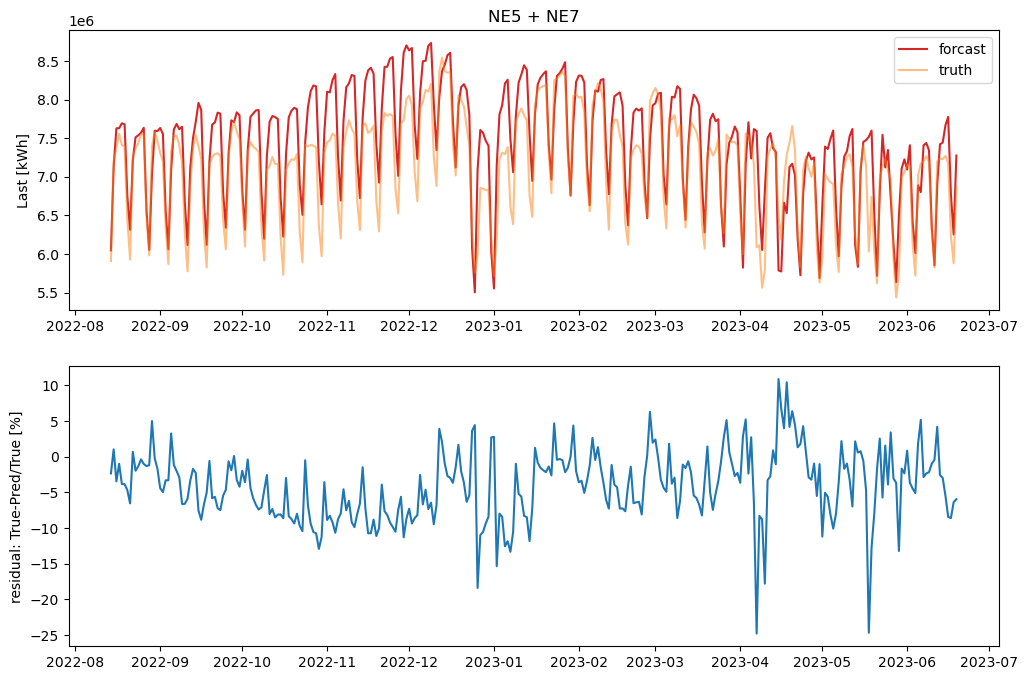

In [21]:

f, axes = plt.subplots(2, 1, figsize=(12, 8))


axes[0].plot(y_pred.ds.values, y_pred.MSTL, color="tab:red", label="forcast")
# axes[0].plot(pdfTrain.ds.values, pdfTrain.y.values, color="tab:blue", label="train")
axes[0].plot(
    pdf_test.ds.values, pdf_test.y.values, color="tab:orange", label="truth", alpha=0.5
)
axes[0].legend()
axes[0].set_title("NE5 + NE7")
axes[0].set_ylabel("Last [kWh]")


xmin, xmax = axes[0].get_xlim()

axes[1].plot(
    pdf_test.ds, (pdf_test.y.values - y_pred.MSTL) / (pdf_test.y.values) * 100
)
axes[1].set_xlim(xmin, xmax)
axes[1].set_ylabel("residual: True-Pred/True [%]")

plt.show()

In [12]:
from sklearn.metrics import mean_squared_error

rmseValue = mean_squared_error(pdf_test.y, y_pred.MSTL, squared=False)
rmseValue

440412.3779731602

In [ ]:
sf.fitted_[0, 0].model_

,data,trend,seasonal7,seasonal365,remainder
0,6709087.0,7.832722e+06,-1.157256e+05,-763485.637562,-244423.802938
1,7073348.0,7.832285e+06,1.375134e+04,-458253.320743,-314434.827657
2,7149544.0,7.831848e+06,-6.946765e+05,-177227.272646,189600.270339
3,6724466.5,7.831410e+06,-1.186923e+06,124343.309351,-44363.964313
4,8585045.0,7.830973e+06,6.130216e+05,143990.196292,-2939.483240
...,...,...,...,...,...
2777,7200342.0,7.491942e+06,3.697658e+05,-504528.334179,-156837.737887
2778,7194131.5,7.492554e+06,4.272148e+05,-425306.831457,-300330.014159
2779,7232487.0,7.493164e+06,4.944120e+05,-388029.679478,-367059.497418
2780,7143698.5,7.493774e+06,4.723405e+05,-372826.994066,-449589.264934


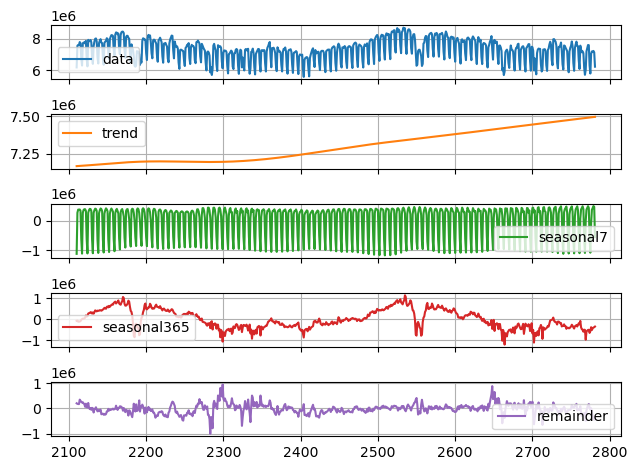

In [ ]:
sf.fitted_[0, 0].model_.tail(24 * 28).plot(subplots=True, grid=True)
plt.tight_layout()
plt.show()